## 1 Thiết lập môi trường & kiểm tra GPU



In [17]:
import torch

In [ ]:
print(torch.cuda.is_available())

In [ ]:
print(torch.cuda.get_device_name(0))

## 2 Khởi tạo mô hình MobileNetV3-Large


In [ ]:
import torchvision.models as models

Trong bài toán phân loại hình ảnh phức tạp với 38 lớp, việc huấn luyện một mạng Neural từ đầu đòi hỏi lượng tài nguyên tính toán khổng lồ và thời gian rất dài. Do đó, nhóm em sử dụng thư viện torchvision.models để áp dụng phương pháp Transfer Learning.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

CUDA (Compute Unified Device Architecture): Là một nền tảng tính toán song song do NVIDIA phát triển. Nếu máy tính hoặc môi trường (như Google Colab) có hỗ trợ GPU NVIDIA, chúng ta sẽ ưu tiên sử dụng nó.

CPU: Trong trường hợp không có GPU, hệ thống sẽ tự động chuyển về sử dụng CPU để đảm bảo chương trình vẫn có thể chạy được, mặc dù tốc độ sẽ chậm hơn.

In [ ]:
model = models.mobilenet_v3_large(weights="IMAGENET1K_V1")
model.classifier[3] = torch.nn.Linear(
    model.classifier[3].in_features, 38
)
model = model.to(device)


## 3 Định nghĩa Transform


Do bộ dữ liệu ImageNet gốc có 1000 lớp, trong khi bài toán của đề tài này chỉ có 38 lớp bệnh cây trồng vì vậy nhóm em thực hiện thay đổi lớp cuối cùng của bộ phân loại:

- Đầu vào: Giữ nguyên số lượng đặc trưng đầu vào từ lớp trước đó của MobileNetV3.

- Đầu ra: Chỉnh thành 38.

- device: Đẩy mô hình lên GPU (CUDA) nếu có để tăng tốc độ tính toán.

In [ ]:
from torchvision import  transforms

Sử dụng thư viện torchvision.transforms để thiết lập một chuỗi các thao tác xử lý ảnh tự động:
- Resize (224x224): Chuyển tất cả hình ảnh về cùng một kích thước chuẩn để phù hợp với đầu vào của các mạng Neural (như ResNet, MobileNet).
- RandomHorizontalFlip & RandomRotation: Tăng cường dữ liệu bằng cách lật và xoay ảnh ngẫu nhiên, giúp mô hình học được các đặc trưng ở nhiều góc độ khác nhau.
- ToTensor: Chuyển đổi hình ảnh từ định dạng PIL Image hoặc NumPy array sang Tensor – cấu trúc dữ liệu mà PyTorch có thể tính toán trên GPU.
- Normalization: Chuẩn hóa giá trị Pixel về khoảng $[0, 1]$ và điều chỉnh theo giá trị trung bình (mean) và độ lệch chuẩn (std) của bộ dữ liệu ImageNet để mô hình hội tụ nhanh hơn.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

tạo train_transform để tăng đa dạng dữ liệu và giảm overfitting 
  - Đưa ảnh về cùng kích thước đầu vào.

  - Lật ngang ngẫu nhiên; phù hợp vì nhiều bệnh lá không phụ thuộc hướng trái/phải.

  - Xoay ngẫu nhiên trong khoảng ±10° để tăng tính bất biến theo góc chụp.

  - Tạo biến thiên ánh sáng/độ tương phản, giúp mô hình bền hơn trước điều kiện chụp khác nhau.

  - Chuyển ảnh sang tensor float32 (C x H x W) trong [0, 1].

  - Chuẩn hoá theo thống kê ImageNet để khớp với pretrained weights.


In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

tạo val_transform với mục tiêu đánh giá công bằng và ổn định.

  - Chuẩn hoá kích thước ảnh đầu vào để model nhận input đồng nhất.
  - Đưa ảnh về tensor dạng float trong khoảng [0, 1], chuyển layout thành C x H x W.
  - Chuẩn hoá phân phối pixel theo thống kê ImageNet để khớp với pretrained backbone.



## 4 Chuẩn bị dữ liệu



In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

- ImageFolder giúp tự động quét cấu trúc thư mục của bộ dữ liệu để gán nhãn tương unhws cho ảnh
- DataLoader là bộ quản lý việc nạp dữ liệu theo từng Batch.

Nhóm em sử dụng torch.cuda.amp để thực hiện kỹ thuật Mixed Precision Training:

- autocast: Tự động chuyển đổi các phép toán phù hợp sang định dạng float16 thay vì float32 mặc định, Việc này giúp giảm một nửa dung lượng bộ nhớ và tăng tốc độ xử lý trên các dòng GPU hiện đại.

- GradScaler: Do sử dụng float16 có thể gây ra hiện tượng mất mát dữ liệu khi đạo hàm quá nhỏ, GradScaler giúp phóng đại các giá trị gradient để duy trì độ chính xác và tính ổn định cho quá trình cập nhật trọng số.

In [ ]:
train_path = "./dataset/NewPlantDiseasesDataset/train"
# valid_path = "./dataset/NewPlantDiseasesDataset/valid"
test_path = "./test"
valid_path = test_path

## 5 EDA/ Visualize dữ liệu



In [ ]:
root = "D:/MachineLearning/baitapnhom/dataset/NewPlantDiseasesDataset/train"
full_ds = ImageFolder(root)

In [ ]:
# train_ds = ImageFolder(train_path, transform=train_transform)
# valid_ds = ImageFolder(valid_path, transform=val_transform)
# test_ds = ImageFolder(test_path, transform=val_transform)


from torch.utils.data import random_split
full_ds = ImageFolder(train_path, transform=train_transform)
train_size = int(0.8 * len(full_ds))
val_size = len(full_ds) - train_size
train_ds, valid_ds = random_split(full_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42))

valid_ds.dataset.transform = val_transform
test_ds = ImageFolder(test_path, transform=val_transform)

### 5.1 Danh sách lớp



In [ ]:
num_classes = len(full_ds.classes)
class_names = full_ds.classes

print("Số lớp: ", num_classes)
print("Các lớp:")
for i, c in enumerate(class_names):
    print(f"{i+1:02d}: {c}")

Số lớp:  38
Các lớp:
01: Apple___Apple_scab
02: Apple___Black_rot
03: Apple___Cedar_apple_rust
04: Apple___healthy
05: Blueberry___healthy
06: Cherry_(including_sour)___Powdery_mildew
07: Cherry_(including_sour)___healthy
08: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
09: Corn_(maize)___Common_rust_
10: Corn_(maize)___Northern_Leaf_Blight
11: Corn_(maize)___healthy
12: Grape___Black_rot
13: Grape___Esca_(Black_Measles)
14: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
15: Grape___healthy
16: Orange___Haunglongbing_(Citrus_greening)
17: Peach___Bacterial_spot
18: Peach___healthy
19: Pepper,_bell___Bacterial_spot
20: Pepper,_bell___healthy
21: Potato___Early_blight
22: Potato___Late_blight
23: Potato___healthy
24: Raspberry___healthy
25: Soybean___healthy
26: Squash___Powdery_mildew
27: Strawberry___Leaf_scorch
28: Strawberry___healthy
29: Tomato___Bacterial_spot
30: Tomato___Early_blight
31: Tomato___Late_blight
32: Tomato___Leaf_Mold
33: Tomato___Septoria_leaf_spot
34: Tomato___Sp

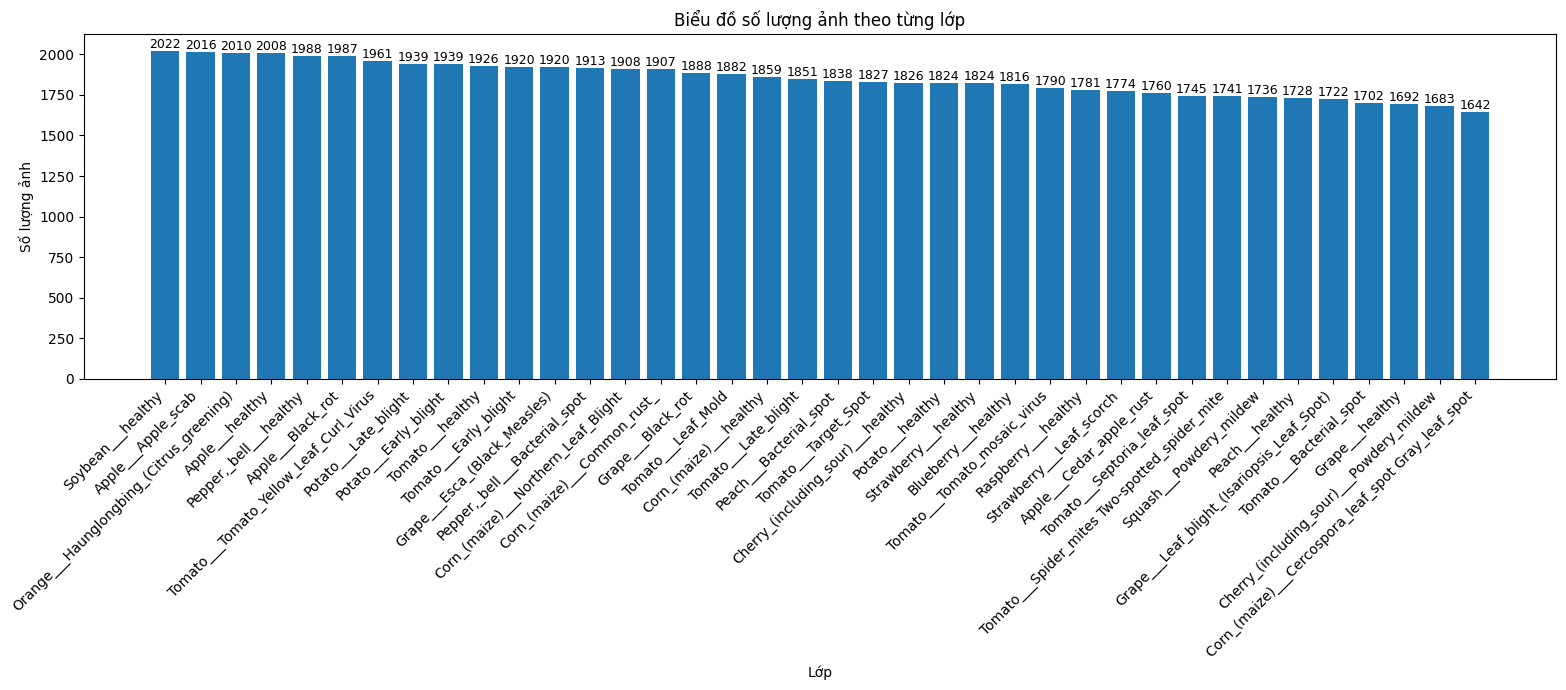

In [28]:
# plot visualization (matplotlib)
from collections import Counter
import pandas as pd

labels = [label for _, label in full_ds.samples]
labels_count = Counter(labels)

class_count = {class_names[k]: v for k, v in labels_count.items()}

df_count = pd.DataFrame(
    {"Class": list(class_count.keys()), "num_classes": list(class_count.values())}
).sort_values(by="num_classes", ascending=False)

# matplotlib bar plot + show counts on top of each bar
plt.figure(figsize=(16, 7))
bars = plt.bar(df_count["Class"], df_count["num_classes"])

plt.title("Biểu đồ số lượng ảnh theo từng lớp")
plt.xlabel("Lớp")
plt.ylabel("Số lượng ảnh")
plt.xticks(rotation=45, ha="right")

# annotate each bar with the exact number
for b, v in zip(bars, df_count["num_classes"]):
    plt.text(
        b.get_x() + b.get_width() / 2,
        b.get_height(),
        f"{int(v)}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()


Phân bổ ảnh giữa các nhãn đồng đều không có tình trạng bị lệch, giúp mô hình không bị thiên vị dẫn đến ảnh hưởng kết quả dự đoán.

### 5.2 Over Bright

In [19]:
#check over birhgtness
import cv2
import numpy as np

def is_over_bright(img_path, thresh=0.85):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v = hsv[:, :, 2]/ 255.0
    mean_v = v.mean()
    return mean_v > thresh, mean_v


from tqdm import tqdm
over_stat = []
over_count = Counter()

for img_path, label in tqdm(full_ds.samples):
    is_over, mean_v = is_over_bright(img_path)
    if is_over:
        class_name = class_names[label]
        over_count[class_name] += 1
    over_stat.append((mean_v))
    
df_over = pd.DataFrame.from_dict({
    "Class": list(over_count.keys()),
    "Total Images": [class_count[c] for c in over_count],
    "Over Bright Images": [over_count[c] for c in over_count],
})

df_over['Ratio'] = df_over['Over Bright Images'] / df_over['Total Images']
df_over = df_over.sort_values(by="Ratio", ascending=False)

df_over.head()


100%|██████████| 70295/70295 [00:44<00:00, 1565.24it/s]


,Class,Total Images,Over Bright Images,Ratio
9,Tomato___Tomato_mosaic_virus,1790,295,0.164804
6,Raspberry___healthy,1781,283,0.158899
3,Peach___healthy,1728,239,0.138310
0,Apple___Cedar_apple_rust,1760,206,0.117045
4,"Pepper,_bell___healthy",1988,200,0.100604


Số ảnh vị over brightkhoảng 1.6%, rất ít và nhóm e quyết định vẫn giữ các ảnh đó

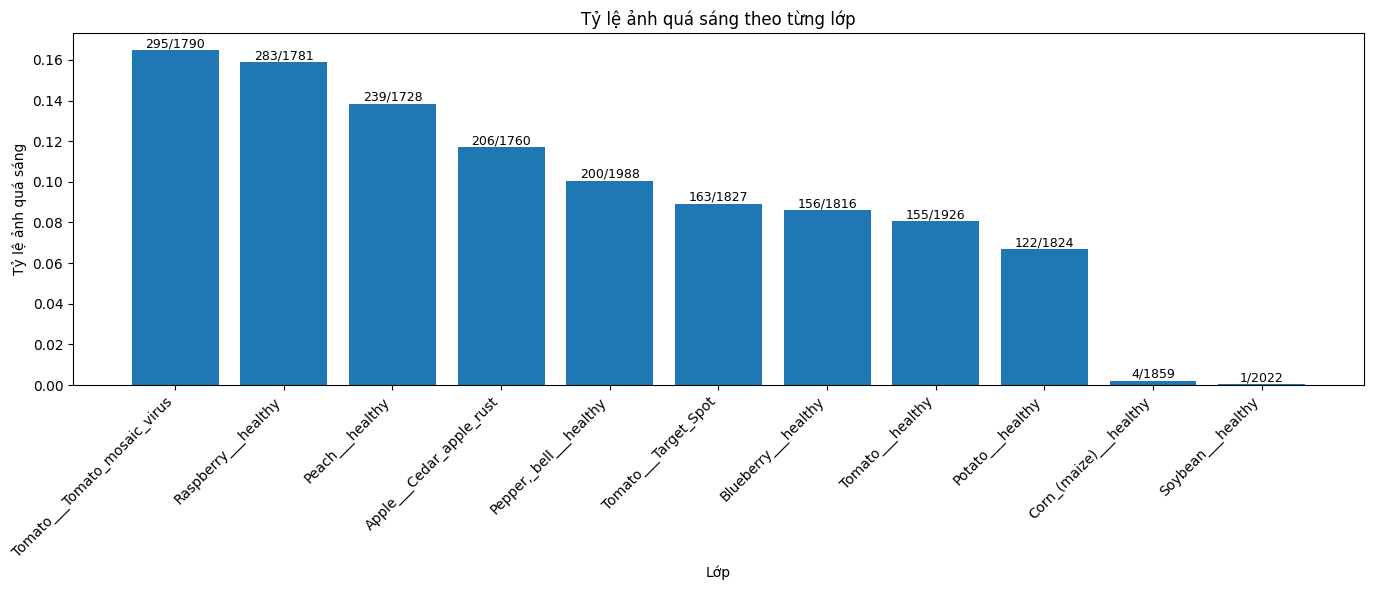

In [27]:
import matplotlib.pyplot as plt
x = df_over["Class"]
y = df_over["Ratio"]

plt.figure(figsize=(14, 6))
bars = plt.bar(x, y)

plt.title("Tỷ lệ ảnh quá sáng theo từng lớp")
plt.xlabel("Lớp")
plt.ylabel("Tỷ lệ ảnh quá sáng")
plt.xticks(rotation=45, ha="right")

# Gắn nhãn số lượng ảnh trên đỉnh cột
for bar, over_n, total_n, ratio in zip(
    bars,
    df_over["Over Bright Images"],
    df_over["Total Images"],
    df_over["Ratio"]
):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{over_n}/{total_n}",
        ha="center",
        va="bottom",
        fontsize=9
    )

plt.tight_layout()
plt.show()

Số ảnh over bright tập trung chủ yếu vào 1 số nhãn nhưng chiếm trọng số khong lớn nên không ảnh hưởng

## 6 DataLoader


In [51]:
train_load = DataLoader(
    train_ds,
    batch_size=64,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
)

valid_load = DataLoader(
    valid_ds,
    batch_size=64,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

Batch size (64): Cân bằng giữa tốc độ huấn luyện và bộ nhớ GPU.

Shuffle (Train): Xáo trộn ảnh để mô hình không học vẹt thứ tự mẫu.

Num workers (8): Sử dụng đa luồng CPU để nạp ảnh song song, tránh nghẽn cổ chai.

Pin memory (True): Tăng tốc độ chuyển dữ liệu từ RAM lên GPU.

In [ ]:
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.amp.GradScaler()
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

Hàm mất mát sử dụng label_smoothing=0.1 để ngăn mô hình quá tự tin overconfident, giúp tăng khả năng tổng quát hóa.

Bộ tối ưu (Adam): Tốc độ học khởi tạo $10^{-3}$ giúp hội tụ nhanh chóng.

## 7 Hàm đánh giá


In [53]:
@torch.no_grad()

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for x, y in val_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)
        loss = criterion(out, y)

        total_loss += loss.item()
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / len(val_loader)
    acc = correct / total

    return avg_loss, acc


@torch.no_grad(): Vô hiệu hóa việc tính toán Gradient, giúp tiết kiệm bộ nhớ và tăng tốc độ tính toán vì chúng ta không cần cập nhật trọng số ở bước này.

model.eval(): Chuyển mô hình sang chế độ đánh giá, đảm bảo các lớp như Dropout hay Batch Normalization hoạt động đúng logic dự báo.

non_blocking=True: Kết hợp với pin_memory=True ở DataLoader để đẩy nhanh quá trình nạp dữ liệu lên GPU mà không làm gián đoạn luồng xử lý của CPU.

## 8 Early Stopping

- Mục đích: dừng sớm khi `val_loss` không còn cải thiện sau một số epoch (`patience`).
- Tránh overfitting và tiết kiệm thời gian train.


In [54]:
#early stop
class EarlyStopping:
    def __init__(self, patience=4, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

patience=4: Số lượng Epoch tối đa mà mô hình có thể chịu đựng khi độ lỗi không cải thiện trước khi dừng hẳn.

min_delta: Ngưỡng cải thiện tối thiểu để được coi là một bước tiến triển tốt.

## 10 Huấn luyện mô hình



In [ ]:
import os
import json

early_stop = EarlyStopping(patience=5)

history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
    "lr": []
}

best_val_loss = float("inf")

for epoch in range(15):
    model.train()
    total_loss = 0.0


    for x, y in train_load:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast():
            out = model(x)
            loss = criterion(out, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    train_loss = total_loss / len(train_load)


    val_loss, val_acc = validate(
        model, valid_load, criterion, device
    )

    lr = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["lr"].append(lr)

    print(
        f"Epoch [{epoch+1}/15] | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Loss: {val_loss:.4f} | "
        f"Val Acc: {val_acc*100:.2f}% | "
        f"LR: {lr}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": val_loss,
            "val_acc": val_acc,
        }, "model_v3.pth")

    if early_stop.step(val_loss):
        print("early access")
        break
    
    if epoch == 7:
        for param_group in optimizer.param_groups:
            param_group["lr"] = 1e-4


Epoch [1/15] | Train Loss: 0.8070 | Val Loss: 0.7622 | Val Acc: 98.33% | LR: 0.001
Epoch [2/15] | Train Loss: 0.7212 | Val Loss: 0.7594 | Val Acc: 97.39% | LR: 0.001
Epoch [3/15] | Train Loss: 0.7100 | Val Loss: 0.7748 | Val Acc: 96.96% | LR: 0.001
Epoch [4/15] | Train Loss: 0.7063 | Val Loss: 0.7126 | Val Acc: 98.88% | LR: 0.001
Epoch [5/15] | Train Loss: 0.7040 | Val Loss: 0.7300 | Val Acc: 98.58% | LR: 0.001
Epoch [6/15] | Train Loss: 0.7002 | Val Loss: 0.7348 | Val Acc: 98.17% | LR: 0.001
Epoch [7/15] | Train Loss: 0.7003 | Val Loss: 0.7012 | Val Acc: 99.08% | LR: 0.001
Epoch [8/15] | Train Loss: 0.6972 | Val Loss: 0.7474 | Val Acc: 97.99% | LR: 0.001
Epoch [9/15] | Train Loss: 0.6791 | Val Loss: 0.6774 | Val Acc: 99.80% | LR: 0.0001
Epoch [10/15] | Train Loss: 0.6759 | Val Loss: 0.6768 | Val Acc: 99.84% | LR: 0.0001
Epoch [11/15] | Train Loss: 0.6752 | Val Loss: 0.6762 | Val Acc: 99.84% | LR: 0.0001
Epoch [12/15] | Train Loss: 0.6746 | Val Loss: 0.6754 | Val Acc: 99.88% | LR: 0.00

Mô hình đạt độ chính xác trên 98% ngay từ Epoch đầu tiên nhờ sức mạnh của phương pháp Transfer Learning với trọng số pre-trained từ ImageNet

Hiệu quả của việc giảm Learning Rate: Tại Epoch 9, khi Learning Rate giảm từ $10^{-3}$ xuống $10^{-4}$, có thể thấy Val Loss giảm mạnh (từ 0.7474 xuống 0.6774) và Val Acc ổn định ở mức cực cao (>99%) chứng tỏ việc điều chỉnh LR đã giúp mô hình thoát khỏi các cực tiểu địa phương và hội tụ sâu hơn

Khoảng cách giữa Train Loss và Val Loss rất nhỏ, đồng thời độ chính xác trên tập Validation duy trì ổn định, cho thấy mô hình không bị hiện tượng Overfitting

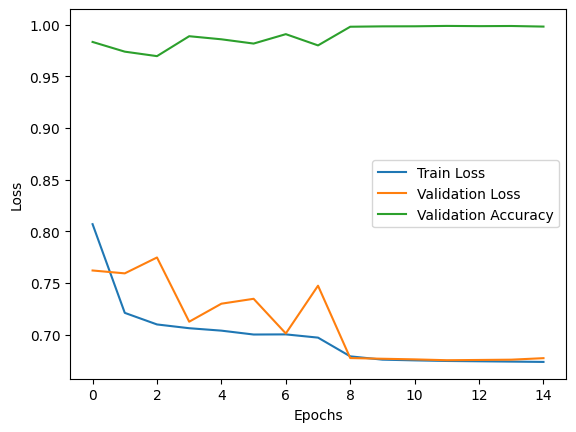

In [57]:
import matplotlib.pyplot as plt
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Giai đoạn ổn định khởi đầu (Epoch 1-8): Cả Train Loss và Validation Loss giảm đều, trong đó Validation Accuracy duy trì ổn định ở mức trên 97%.

Ngay sau khi thực hiện giảm Learning Rate từ $0.001$ xuống $0.0001$ ở epoch 9, đường cong Validation Loss có sự sụt giảm mạnh mẽ, đồng thời Validation Accuracy tiệm cận mức tuyệt đối (99.80%).


## 11 Thử mô hình với tập test

In [64]:
from PIL import Image
from pathlib import Path

checkpoint = torch.load("model_v3.pth", map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

test_root = Path(test_path)

img_paths = [
    p for p in test_root.rglob("*")
    if p.is_file() and p.suffix.lower() in ".jpg"
]

if not img_paths:
    raise FileNotFoundError(f"No image files found under: {test_root.resolve()}")

for p in sorted(img_paths):
    img = Image.open(p).convert("RGB")
    x = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(x)
        pred = int(out.argmax(dim=1).item())

    print(p.name, full_ds.classes[pred])

AppleCedarRust1.JPG Apple___Cedar_apple_rust
AppleCedarRust2.JPG Apple___Cedar_apple_rust
AppleCedarRust3.JPG Apple___Cedar_apple_rust
AppleCedarRust4.JPG Apple___Cedar_apple_rust
AppleScab1.JPG Apple___Apple_scab
AppleScab2.JPG Apple___Apple_scab
AppleScab3.JPG Apple___Apple_scab
CornCommonRust1.JPG Corn_(maize)___Common_rust_
CornCommonRust2.JPG Corn_(maize)___Common_rust_
CornCommonRust3.JPG Corn_(maize)___Common_rust_
PotatoEarlyBlight1.JPG Potato___Early_blight
PotatoEarlyBlight2.JPG Potato___Early_blight
PotatoEarlyBlight3.JPG Potato___Early_blight
PotatoEarlyBlight4.JPG Potato___Early_blight
PotatoEarlyBlight5.JPG Potato___Early_blight
PotatoHealthy1.JPG Potato___healthy
PotatoHealthy2.JPG Potato___healthy
TomatoEarlyBlight1.JPG Tomato___Early_blight
TomatoEarlyBlight2.JPG Tomato___Early_blight
TomatoEarlyBlight3.JPG Tomato___Early_blight
TomatoEarlyBlight4.JPG Tomato___Early_blight
TomatoEarlyBlight5.JPG Tomato___Early_blight
TomatoEarlyBlight6.JPG Tomato___Early_blight
TomatoH

Kết quả dự đoán trên các tệp tin hình ảnh độc lập cho thấy mô hình đạt độ chính xác tuyệt đối trên tập mẫu thử:

Các mẫu bệnh như AppleScab, CornCommonRust, PotatoEarlyBlight đều được gán nhãn chính xác tương ứng với tên lớp trong tập dữ liệu.

Ngay cả các nhãn phức tạp như Tomato___Tomato_Yellow_Leaf_Curl_Virus cũng được nhận diện không sai sót.

## 12 Lưu mô hình 



In [ ]:
#resume train
checkpoint = torch.load("model.pth")
model.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
start_epoch = checkpoint["epoch"] + 1
